In [1]:
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
import nltk
from nltk.corpus import stopwords
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

In [3]:
import re
import string

In [4]:
# 1. Get the dataset from Hugging Face
dataset_name = "cnamuangtoun/resume-job-description-fit"
try:
    dataset = load_dataset(dataset_name)
    df = dataset['train'].to_pandas()
    print(f"Dataset '{dataset_name}' loaded successfully. Shape: {df.shape}")
    print("Column names in the DataFrame:")
    print(df.columns)
    # We need to identify the correct column names for text and labels
    TEXT_COLUMN = None  # We will update this based on the output
    LABEL_COLUMN = None # We will update this based on the output
except Exception as e:
    print(f"Error loading dataset '{dataset_name}': {e}")
    exit()

Dataset 'cnamuangtoun/resume-job-description-fit' loaded successfully. Shape: (6241, 3)
Column names in the DataFrame:
Index(['resume_text', 'job_description_text', 'label'], dtype='object')


In [5]:
# 2. Preprocessing
TEXT_COLUMN_RESUME = 'resume_text'
TEXT_COLUMN_JOB = 'job_description_text'
LABEL_COLUMN = 'label'

stop_words = set(stopwords.words('english'))
custom_stopwords = ['e.g.', 'i.e.', 'etc.', 'the', 'and', 'a', 'an', 'in', 'of', 'to'] # Add more if needed
stop_words.update(custom_stopwords)

def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase
        text = text.lower()
        # Remove email addresses
        text = re.sub(r'\S*@\S*\s?', '', text)
        # Remove non-ASCII characters
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        # Remove numbers (keeping those with % $ or year format)
        text = re.sub(r'(?<!\d)(?<![\$\%])\b\d+\b', '', text)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove stopwords
        text_tokens = text.split()
        filtered_tokens = [w for w in text_tokens if not w in stop_words]
        return " ".join(filtered_tokens)
    return ""

print("Applying preprocessing...")
df['processed_resume'] = df[TEXT_COLUMN_RESUME].apply(preprocess_text)
df['processed_job_description'] = df[TEXT_COLUMN_JOB].apply(preprocess_text)
# Combine processed resume and job description for the model
df['combined_text'] = df['processed_resume'] + ' ' + df['processed_job_description']
df = df[df['combined_text'].str.len() > 0] # Remove rows with empty combined text
print("Preprocessing complete.")

Applying preprocessing...
Preprocessing complete.


In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['combined_text'], df[LABEL_COLUMN], test_size=0.2, random_state=42)

# Text vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert TF-IDF sparse matrix to dense array for GaussianNB
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

In [7]:
# Initialize and train the models
gnb = GaussianNB()
gnb.fit(X_train_dense, y_train)
gnb_predictions = gnb.predict(X_test_dense)


# Evaluate the models
print("Gaussian Naive Bayes:")
print(classification_report(y_test, gnb_predictions))
print("Accuracy:", accuracy_score(y_test, gnb_predictions))

Gaussian Naive Bayes:
               precision    recall  f1-score   support

     Good Fit       0.52      0.82      0.63       303
       No Fit       0.74      0.28      0.40       658
Potential Fit       0.37      0.68      0.48       288

     accuracy                           0.50      1249
    macro avg       0.55      0.59      0.51      1249
 weighted avg       0.60      0.50      0.48      1249

Accuracy: 0.5012009607686149


In [8]:
cnb = ComplementNB()
cnb.fit(X_train_tfidf, y_train)
cnb_predictions = cnb.predict(X_test_tfidf)

print("\nComplement Naive Bayes:")
print(classification_report(y_test, cnb_predictions))
print("Accuracy:", accuracy_score(y_test, cnb_predictions))


Complement Naive Bayes:
               precision    recall  f1-score   support

     Good Fit       0.50      0.29      0.37       303
       No Fit       0.58      0.84      0.68       658
Potential Fit       0.46      0.18      0.26       288

     accuracy                           0.55      1249
    macro avg       0.51      0.44      0.44      1249
 weighted avg       0.53      0.55      0.51      1249

Accuracy: 0.5540432345876701


In [9]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf, y_train)
rf_predictions = rf.predict(X_test_tfidf)

print("\nRandom Forest:")
print(classification_report(y_test, rf_predictions))
print("Accuracy:", accuracy_score(y_test, rf_predictions))


Random Forest:
               precision    recall  f1-score   support

     Good Fit       0.60      0.57      0.59       303
       No Fit       0.66      0.79      0.72       658
Potential Fit       0.57      0.34      0.43       288

     accuracy                           0.63      1249
    macro avg       0.61      0.57      0.58      1249
 weighted avg       0.62      0.63      0.62      1249

Accuracy: 0.633306645316253


In [7]:
label_mapping = {'No Fit': 0, 'Potential Fit': 1, 'Good Fit': 2}
y_train_encoded = y_train.map(label_mapping)

y_test_encoded = y_test.map(label_mapping)


xgb_classifier = xgb.XGBClassifier(random_state=42,n_estimators = 100,learning_rate= 0.01,max_depth =15)
xgb_classifier.fit(X_train_tfidf, y_train_encoded)
xgb_predictions = xgb_classifier.predict(X_test_tfidf)

print("\nXGBoost:")
print(classification_report(y_test_encoded, xgb_predictions))
print("Accuracy:", accuracy_score(y_test_encoded, xgb_predictions))


XGBoost:
              precision    recall  f1-score   support

           0       0.70      0.80      0.74       658
           1       0.60      0.42      0.49       288
           2       0.68      0.66      0.67       303

    accuracy                           0.68      1249
   macro avg       0.66      0.62      0.63      1249
weighted avg       0.67      0.68      0.67      1249

Accuracy: 0.6765412329863891


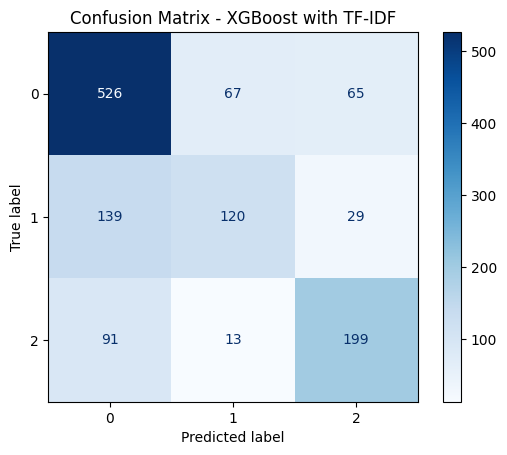

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, xgb_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost with TF-IDF")
plt.show()